# Missing data imputation using optimal transport

In this notebook, we will show how to use optimal transport to impute missing values in an incomplete dataset.

The methods we will use are described in the following paper:

B. Muzellec, J. Josse, C. Boyer, M. Cuturi, [Missing Data Imputation using Optimal Transport](https://arxiv.org/pdf/2002.03860.pdf).

## Imports and installs

In [5]:
# Ignore this cell if the corresponding packages are already installed

!pip install pot
!pip install geomloss

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

import os

from geomloss import SamplesLoss

from imputers import OTimputer, RRimputer

from utils import *
from data_loaders import dataset_loader
from softimpute import softimpute, cv_softimpute

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

## Data loading

The dataset loader utilities assume there is a "datasets/" folder in the current directory.

In [7]:
if not os.path.isdir("datasets"):
    os.mkdir("datasets")

Load the data and whiten it.
In a real missing data situation, the mean and std would have to be estimated on non-missing data.

In [8]:
ground_truth = scale(dataset_loader("wine")) # "wine" can be replaced with any of the datasets
                                             # supported by dataset_loader (see data_loaders.py)

X_true = torch.from_numpy(ground_truth)

In [20]:
ground_truth

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

In [21]:
X_true

tensor([[ 1.5186, -0.5622,  0.2321,  ...,  0.3622,  1.8479,  1.0130],
        [ 0.2463, -0.4994, -0.8280,  ...,  0.4061,  1.1134,  0.9652],
        [ 0.1969,  0.0212,  1.1093,  ...,  0.3183,  0.7886,  1.3951],
        ...,
        [ 0.3328,  1.7447, -0.3894,  ..., -1.6121, -1.4854,  0.2806],
        [ 0.2092,  0.2277,  0.0127,  ..., -1.5683, -1.4007,  0.2965],
        [ 1.3951,  1.5832,  1.3652,  ..., -1.5244, -1.4289, -0.5952]])

## Missing data generation

Let's now simulate missing data. We will assume that the data is missing completely at random (MCAR) with a 50% probability.
Additional MAR and MNAR missing data mechanisms are available in utils.py.

In [9]:
np.random.seed(42)

p = 0.5

mask = np.random.rand(*ground_truth.shape) < p #True for missing values, false for others
x_miss = np.copy(ground_truth)

x_miss[mask] = np.nan
X_miss = torch.from_numpy(x_miss)

In [22]:
X_miss

tensor([[    nan, -0.5622,  0.2321,  ...,     nan,  1.8479,  1.0130],
        [    nan,     nan,     nan,  ...,     nan,     nan,  0.9652],
        [    nan,  0.0212,  1.1093,  ...,     nan,     nan,  1.3951],
        ...,
        [ 0.3328,  1.7447, -0.3894,  ...,     nan, -1.4854,     nan],
        [    nan,     nan,  0.0127,  ...,     nan,     nan,  0.2965],
        [ 1.3951,  1.5832,     nan,  ..., -1.5244,     nan, -0.5952]])

## Hyperparameters

In [10]:
n, d = X_miss.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon = pick_epsilon(X_miss) # Set the regularization parameter as a multiple of the median distance, as per the paper.

## Sinkhorn imputation (Algorithm 1)

In [11]:
sk_imputer = OTimputer(eps=epsilon, batchsize=batchsize, lr=lr, niter=2000)

In [12]:
sk_imp, sk_maes, sk_rmses = sk_imputer.fit_transform(X_miss, verbose=True, report_interval=500, X_true=X_true)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:batchsize = 64, epsilon = 0.2697
INFO:root:Iteration 0:	 Loss: 1.5291	 Validation MAE: 0.8639	RMSE: 1.0581
INFO:root:Iteration 500:	 Loss: 1.0695	 Validation MAE: 0.6283	RMSE: 0.8598
INFO:root:Iteration 1000:	 Loss: 0.9570	 Validation MAE: 0.6234	RMSE: 0.8592
INFO:root:Iteration 1500:	 Loss: 1.1069	 Validation MAE: 0.6269	RMSE: 0.8640


2000

## Round-robin imputation (Algorithm 3)

Round-robin imputation models iteratively impute each variable using all the other variables.
The imputation is performed according to an optimal transport criterion, as in Algorithm 3 in the paper.
Any model can be used to perform the variable imputation. It is even possible to specify one type of model per variable
(e.g. predict a variable with a linear model, and an other with an MLP), as long as those models gave trainable parameters.

We give here two examples. In the first, variables are predicted using linear models, and in the second using a MLP.

Note that even if each variable has an associated model of the same type as the others,
those models have distinct sets of parameters.

### Linear round-robin

In [13]:
#Create the imputation models
d_ = d - 1
models = {}

for i in range(d):
    models[i] = nn.Linear(d_, 1)

#Create the imputer
lin_rr_imputer = RRimputer(models, eps=epsilon, lr=lr)

In [14]:
lin_imp, lin_maes, lin_rmses = lin_rr_imputer.fit_transform(X_miss, verbose=True, X_true=X_true)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.7924	Validation MAE: 0.7547	RMSE:  0.9723
INFO:root:Iteration 1:	 Loss: 1.3775	Validation MAE: 0.7091	RMSE:  0.9337
INFO:root:Iteration 2:	 Loss: 1.4092	Validation MAE: 0.6951	RMSE:  0.9177
INFO:root:Iteration 3:	 Loss: 1.3401	Validation MAE: 0.6839	RMSE:  0.9032
INFO:root:Iteration 4:	 Loss: 1.3206	Validation MAE: 0.6732	RMSE:  0.8946
INFO:root:Iteration 5:	 Loss: 1.2974	Validation MAE: 0.6715	RMSE:  0.8924
INFO:root:Iteration 6:	 Loss: 1.2869	Validation MAE: 0.6668	RMSE:  0.8893
INFO:root:Iteration 7:	 Loss: 1.2939	Validation MAE: 0.6682	RMSE:  0.8933
INFO:root:Iteration 8:	 Loss: 1.3819	Validation MAE: 0.6659	RMSE:  0.8918
INFO:root:Iteration 9:	 Loss: 1.2432	Validation MAE: 0.6672	RMSE:  0.8930
INFO:root:Early stopping criterion not reached


### MLP round-robin

In [15]:
#Create the imputation models
d_ = d - 1
models = {}

for i in range(d):
    models[i] = nn.Sequential(nn.Linear(d_, 2 * d_),
                              nn.ReLU(),
                              nn.Linear(2 * d_, d_),
                              nn.ReLU(),
                              nn.Linear(d_, 1))

#Create the imputer
mlp_rr_imputer = RRimputer(models, eps=epsilon, lr=lr)

In [16]:
mlp_imp, mlp_maes, mlp_rmses = mlp_rr_imputer.fit_transform(X_miss, verbose=True, X_true=X_true)

INFO:root:Batchsize larger that half size = 89. Setting batchsize to 64.
INFO:root:Iteration 0:	 Loss: 1.2569	Validation MAE: 0.6824	RMSE:  0.9010
INFO:root:Iteration 1:	 Loss: 1.2359	Validation MAE: 0.6548	RMSE:  0.8830
INFO:root:Iteration 2:	 Loss: 1.3309	Validation MAE: 0.6460	RMSE:  0.8799
INFO:root:Iteration 3:	 Loss: 1.3115	Validation MAE: 0.6566	RMSE:  0.8875
INFO:root:Iteration 4:	 Loss: 1.6874	Validation MAE: 0.6626	RMSE:  0.8994
INFO:root:Iteration 5:	 Loss: 1.2471	Validation MAE: 0.6704	RMSE:  0.9179
INFO:root:Iteration 6:	 Loss: 1.3323	Validation MAE: 0.6834	RMSE:  0.9330
INFO:root:Iteration 7:	 Loss: 1.2309	Validation MAE: 0.6865	RMSE:  0.9400
INFO:root:Iteration 8:	 Loss: 1.2040	Validation MAE: 0.6876	RMSE:  0.9374
INFO:root:Iteration 9:	 Loss: 1.2616	Validation MAE: 0.6864	RMSE:  0.9395
INFO:root:Early stopping criterion not reached


## Baselines

Let's compare OT imputations to some baselines. As in the paper, we consider the following baselines: (i) mean imputation, (ii) iterated conditional ridge regression and (iii) softimpute.

In [17]:
# Imputation by the means
mean_imp = SimpleImputer().fit_transform(x_miss)
mean_mae = MAE(mean_imp, ground_truth, mask)
mean_rmse = RMSE(mean_imp, ground_truth, mask)

# ICE
ice_imp = IterativeImputer(random_state=0, max_iter=50).fit_transform(x_miss)
ice_mae = MAE(ice_imp, ground_truth, mask)
ice_rmse = RMSE(ice_imp, ground_truth, mask)

# Softimpute
cv_error, grid_lambda = cv_softimpute(x_miss, grid_len=15)
lbda = grid_lambda[np.argmin(cv_error)]
soft_imp = softimpute((x_miss), lbda)[1]

soft_mae = MAE(soft_imp, ground_truth, mask)
soft_rmse = RMSE(soft_imp, ground_truth, mask)

## Comparison plots

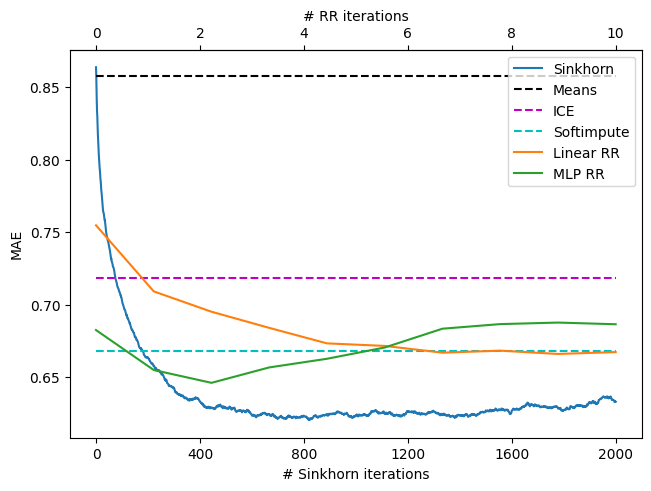

In [18]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

secax = ax.secondary_xaxis('top', functions=(lambda x: x * len(lin_maes) / npoints, lambda x: x * npoints / len(lin_maes)))
secax.set_xlabel('# RR iterations')

ax.plot(np.linspace(0, 1, len(lin_maes)) * npoints, lin_maes, label='Linear RR')
ax.plot(np.linspace(0, 1, len(mlp_maes)) * npoints, mlp_maes, label='MLP RR')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

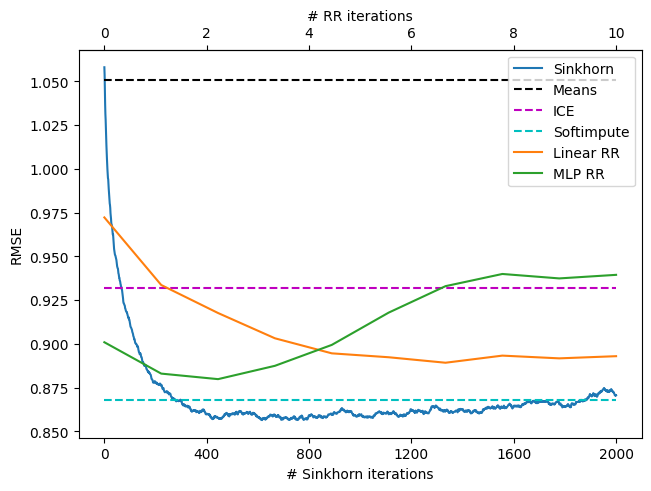

In [19]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

secax = ax.secondary_xaxis('top', functions=(lambda x: x * len(lin_maes) / npoints, lambda x: x * npoints/ len(lin_maes)))
secax.set_xlabel('# RR iterations')

ax.plot(np.linspace(0, 1, len(lin_rmses)) * npoints, lin_rmses, label='Linear RR')
ax.plot(np.linspace(0, 1, len(mlp_maes)) * npoints, mlp_rmses, label='MLP RR')

ax.set_ylabel('RMSE')
plt.legend()
plt.show()



